# Case 1 - Elastic-Net Regression

1. **Importing Libraries**

2. **Loading Data**

3. **Elastic Net Regression**
- Elastic Net Regression because we have many variables that we do not know. Elastic Net combines the strengths of Lasso regression (L1) and Ridge regression. Lasso regression can shrink parameters to 0 which is useful for large dataset where some parameters might be useless. Ridge regression tends to perform better when parameters are not useless. Therefore, elastic net is useful in this case as we do not know our parameters.
- Find optimal model parameters, lamdba_1 and lambda_2 by using 5-fold cross validation.
- Get root mean squared error (RMSE) by applying the model with the optimal model parameters on the test data.

## 1. Importing Libraries

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set searborn as default

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import warnings

# Set seed for reproducibility
import random
random.seed(42)

## 2. Loading Data

In [ ]:
# Loading the data into numpy arrays
X_train = np.loadtxt('../data/case1Data_Xtrain.csv', delimiter=',')
X_test = np.loadtxt('../data/case1Data_Xtest.csv', delimiter=',')
y_train = np.loadtxt('../data/case1Data_ytrain.csv', delimiter=',')
y_test = np.loadtxt('../data/case1Data_ytest.csv', delimiter=',')

### Summary of the data

This should be similar to the summary in case_1_data_wrangling.ipynb.

In [ ]:
# Printing the shape of the data
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

# Size of the training and test data
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]

# Printing the size of the training and test data
print("n_train: ", n_train) # number of training samples
print("n_test: ", n_test) # number of test samples
print("p: ", p) # number of features/variables/columns/parameters

# Checking for missing values in the wrangled data
missing_values_X_train = np.isnan(X_train)
print("Number of missing values in X_train: ", np.sum(missing_values_X_train))
missing_values_X_test = np.isnan(X_test)
print("Number of missing values in X_test: ", np.sum(missing_values_X_test))
missing_values_y_train = np.isnan(y_train)
print("Number of missing values in y_train: ", np.sum(missing_values_y_train))
missing_values_y_test = np.isnan(y_test)
print("Number of missing values in y_test: ", np.sum(missing_values_y_test))

# 3. Elastic Net Regression

**Alpha**
- Definition: Alpha is the regularization strength parameter in Elastic Net.
- Role: It controls the overall strength of regularization applied to the model.
- Values:
    - For α=0: No regularization is applied, and Elastic Net becomes equivalent to Ordinary Least Squares (OLS) regression.
    - For α=1: Both L1 and L2 regularization are applied, combining the penalties of Lasso and Ridge.
    - For 0<α<1: Elastic Net applies a mixture of L1 and L2 regularization, allowing for a flexible combination of penalties.

**L1 Ratio (l1_ratio)**
- Definition: L1 ratio is the mixing parameter that determines the balance between L1 and L2 penalties.
- Role: It controls the proportion of the penalty assigned to the L1 norm relative to the L2 norm.
- Values:
    - For l1_ratio=0: Elastic Net applies only L2 regularization (equivalent to Ridge regression).
    - For l1_ratio=1: Elastic Net applies only L1 regularization (equivalent to Lasso regression).
    - For 0<l1_ratio<1: Elastic Net applies a combination of both L1 and L2 regularization, allowing for a mix of penalties.

### 5-fold Cross Validation

In [ ]:
# Setting a range of alphas to test. Testing a range from very weak to strong regularization.
alphas = np.logspace(-4, 1, 100)

# Setting a range of l1_ratios. Testing a range from L2 (0) to L1 (1) regularization
l1_ratios = np.concatenate(([0], np.logspace(-10, 0, 100)))

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    # Fitting the Elastic Net model on the training data
    model = ElasticNetCV(cv=3, l1_ratio = l1_ratios, alphas=alphas, fit_intercept=False).fit(X_train, y_train)

# Printing the optimal alpha
print(f'Optimal alpha: {model.alpha_}\n')
print('For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.')
print(f'Optimal l1_ratio: {model.l1_ratio_}')

# Plotting the cross-validated mean squared error of the Elastic Net Fit
#plt.close('all')
#plt.figure()
#plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k', label='Average across folds', linewidth=2)
#plt.xlabel(r'$\alpha$ (Regularization strength)')
#plt.ylabel('Mean squared error')
#plt.title(f'Cross-validated MSE of Elastic Net Fit (Optimal alpha = {model.alpha_:.3f})')
#plt.show()

# Using the optimal lambda from the ElasticNetCV model to predict the target values on the test data
y_hat = model.predict(X_test)

# Calculating the RMSE of the ElasticNetCV model
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

# Printing the RMSE
print('Root MSE from OLS with elastic net regression and cross validation to find optimal lambda and model parameters:')
print(f'RMSE: {rmse}')

### Nested 5-fold Cross Validation

In [13]:
X = np.loadtxt('../data/case1Data_X.csv', delimiter=',')
y = np.loadtxt('../data/case1Data_y.csv', delimiter=',')

# Setting a range of alphas and l1_ratios to test
alphas = np.logspace(-4, 1, 100) # Testing a range from very weak to strong regularization
l1_ratios = np.concatenate(([0], np.logspace(-10, 0, 100))) # Testing a range from L2 (0) to L1 (1) regularization

# Outer 5-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
alpha_scores = []
l1_ratio_scores = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Inner loop for hyperparameter tuning (5-fold CV)
    with warnings.catch_warnings():  # Suppress convergence warnings
        warnings.simplefilter("ignore")
        model = ElasticNetCV(cv=5, l1_ratio=l1_ratios, alphas=alphas, fit_intercept=False).fit(X_train, y_train)

    # Evaluate on the outer test set
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Save the optimal alpha
    alpha_scores.append(model.alpha_)

    # Save the optimal l1_ratio
    l1_ratio_scores.append(model.l1_ratio_)

    # Saving the optimal model
    if rmse == min(rmse_scores):
        best_model = model

    # Print the results of the inner loop
    print(f'Fold RMSE: {rmse:.4f}')
    print(f'Optimal alpha: {model.alpha_}')
    print(f'Optimal l1_ratio: {model.l1_ratio_}\n')

# Final performance
print(f'Average RMSE across outer folds: {np.mean(rmse_scores):.4f}')
print(f'Average alpha: {np.mean(alpha_scores)}')
print(f'Average l1_ratio: {np.mean(l1_ratio_scores)}')
# Standard deviation of the RMSE tells us how much the RMSE varies between the folds (i.e., how stable the model is)
print(f'Standard deviation of RMSE: {np.std(rmse_scores):.4f}')


Fold RMSE: 28.1190
Optimal alpha: 0.8697490026177834
Optimal l1_ratio: 1.0

Fold RMSE: 21.5627
Optimal alpha: 0.6892612104349695
Optimal l1_ratio: 1.0

Fold RMSE: 25.1898
Optimal alpha: 1.0974987654930568
Optimal l1_ratio: 1.0

Fold RMSE: 25.0510
Optimal alpha: 1.5556761439304723
Optimal l1_ratio: 1.0

Fold RMSE: 28.7403
Optimal alpha: 0.9770099572992247
Optimal l1_ratio: 1.0

Average RMSE across outer folds: 25.7325
Average alpha: 1.0378390159551014
Average l1_ratio: 1.0
Standard deviation of RMSE: 2.5647


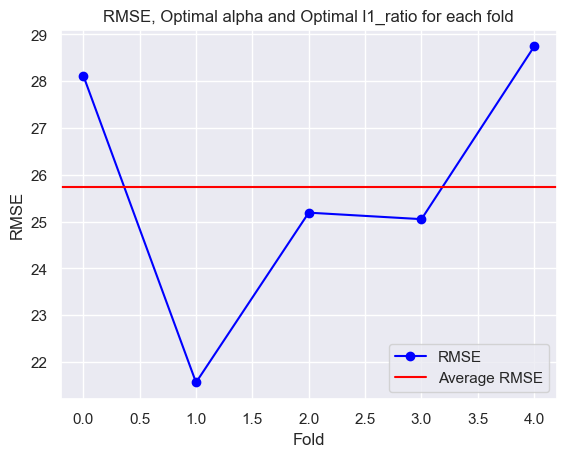

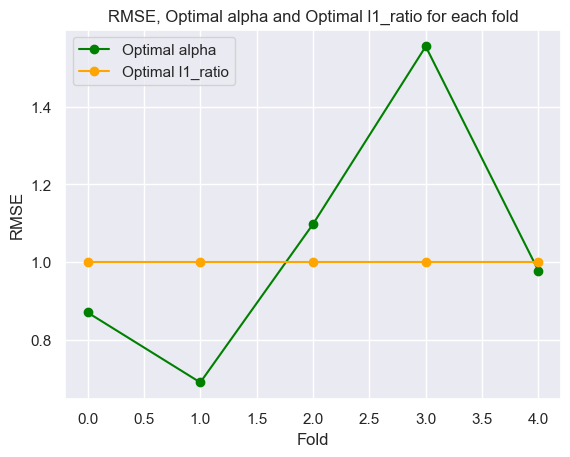

In [15]:
# Plotting the RMSE scores, optimal alpha and optimal l1_ratio for each fold
plt.close('all')
plt.figure()
plt.plot(rmse_scores, 'o-', label='RMSE', color='blue')
plt.axhline(np.mean(rmse_scores), label='Average RMSE', color='red')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE, Optimal alpha and Optimal l1_ratio for each fold')
plt.legend()
plt.show()

plt.close('all')
plt.figure()
plt.plot(alpha_scores, 'o-', label='Optimal alpha', color='green')
plt.plot(l1_ratio_scores, 'o-', label='Optimal l1_ratio', color='orange')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE, Optimal alpha and Optimal l1_ratio for each fold')
plt.legend()
plt.show()

## 3.1 Predicting $\hat{y}$ in the new data set (case1Data_Xnew.csv)

### 3.1.1 Loading case1Data_Xnew_wrangled.csv

In [16]:
# Loading the data into numpy arrays
X_new = np.loadtxt('../data/case1Data_Xnew_wrangled.csv', delimiter=',')
print("X_new: ", X_new.shape)


X_new:  (1000, 116)


### 3.1.2 Predicting and saving predictions in a new file

In [17]:
# Predicting y_hat for the data in case1Data_Xnew.csv
y_hat_new = best_model.predict(X_new)

# Printing the shape of the new data
print(y_hat_new.shape)

# Saving the predictions to a csv file
np.savetxt('../results/sample_predictions_s183220_s225001.csv', y_hat_new, delimiter='\n')

(1000,)


### 3.1.3 Writing the Estimated RMSE to File

In [26]:
# We will use the average RMSE across the outer folds as the expected RMSE
# Saving the value as float with 2 decimals precision
print(f'Expected RMSE: {np.mean(rmse_scores):.2f}')
np.savetxt('../results/sample_estimatedRMSE_s183220_s225001.csv', [np.mean(rmse_scores)], fmt='%.2f')

Expected RMSE: 25.73
